# Phase field damage

Classical framework of brittle fracture, where the bulk energy competes with the dissipated energy via energy minimization, have following form

\begin{equation}
\mathcal{E}(\mathbf{u},\Gamma) =  \int_{\Omega\setminus\Gamma} {\psi_\text{e}({\boldsymbol\varepsilon(\mathbf{u})})
    }\mathrm{d}V + G_\mathrm{f}\int_{\Gamma}\,\mathrm{d}S - \int_{\Omega}\mathbf{b}\cdot\mathbf{u} \mathrm{d}V -
\int_{\partial\Omega}  \mathbf{g}\cdot\mathbf{u}\mathrm{d}S,
\end{equation}

\begin{equation}
    \{\mathbf{u}(\mathbf{x}), \Gamma\} = \mathrm{argmin}_{\{\tilde{\mathbf{u}}, \tilde{\Gamma}\in\mathcal{U}\times\mathcal{G}\}}\ \mathcal{E}(\tilde{\mathbf{u}}, \tilde{\Gamma}),
\end{equation}

$\mathbf{u}$ is displacement, $\Gamma$ is crack, $\mathcal{U}$ is set of kinematically admissible displacements, $\mathcal{G}$ is set of topologically admissible cracks, $\psi$ is elastic deformation energy, $G_\mathrm{f}$ is fracture toughness.

Regularization and smearing of crack

\begin{equation}
\mathcal{E}({\mathbf u},d) =  \int_{\Omega} {g(d)\psi_\text{e}({\boldsymbol\varepsilon(\mathbf{u})})
    }\mathrm{d}V + C\int_{\Omega}\frac{1}{l}d + l | \nabla d |^2\mathrm{d}V - \int_{\Omega}\mathbf{b}\cdot\mathbf{u} \mathrm{d}V -
\int_{\partial\Omega}  \mathbf{g}\cdot\mathbf{u}\mathrm{d} S.
\end{equation}

\begin{equation}
    \{\mathbf{u}(\mathbf{x}), d\} = \mathrm{argmin}_{\{\tilde{\mathbf{u}}, \tilde{d}\in\mathcal{U}\times\mathcal{D}\}}\ \mathcal{E}(\tilde{\mathbf{u}}, \tilde{d}),
\end{equation}

from physical consideration $C=3G_\mathrm{f}/8$ and $l$ is regularization parameter. Function $g(d)=(1-d)^2$ is called degradation function.

### Monolithic solver

\begin{equation}
    \{\mathbf{u}(\mathbf{x}), d\} = \mathrm{argmin}_{\{\tilde{\mathbf{u}}, \tilde{d}\in\mathcal{U}\times\mathcal{D}\}}\ \mathcal{E}(\tilde{\mathbf{u}}, \tilde{d}),
\end{equation}

### Staggered solver (operator splitting?)

\begin{equation}
    \mathbf{u}_i = \mathrm{argmin}_{\tilde{\mathbf{u}}\in\mathcal{U}}\ \mathcal{E}(\tilde{\mathbf{u}}, d_{i-1}),\\
    d_i = \mathrm{argmin}_{\tilde{d}\in\mathcal{D}}\ \mathcal{E}(\mathbf{u}_i, \tilde{d}),
\end{equation}
repeated until converges

### Implementation
> TODO: Jarda

## Mess

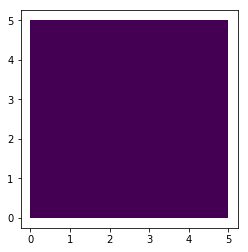

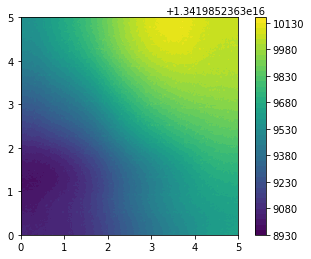

In [11]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


def top(x, on_boundary):
    return (on_boundary and fe.near(x[1], l_y))


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


def psi(u):
    return 0.5*fe.inner(epsilon(u), sigma(u))


# --------------------
# Parameters
# --------------------
# Lame's constants
lmbda = 1.25
mu = 1

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 200, 200  # Number of elements

# Load
b_int = 0.0
C = 1.0
l_c = 0.1

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
b = fe.Constant((0.0, b_int))
P1 = fe.VectorElement("P", fe.triangle, 1)
P2 = fe.FiniteElement("P", fe.triangle, 1)
element = fe.MixedElement([P1, P2])
M = fe.FunctionSpace(mesh, element)
u_tr, d_tr = fe.TrialFunctions(M)
u_test, d_test = fe.TestFunctions(M)
X = fe.Function(M)
u, d = fe.split(X)

# --------------------
# Boundary conditions
# --------------------
u_d = fe.Expression("t", t=0.0, degree=0)
bc1 = fe.DirichletBC(M.sub(0), fe.Constant((0.0, 0.0)), bottom)
#bc2 = fe.DirichletBC(V.sub(0).sub(0), u_d, top)
#bc3 = fe.DirichletBC(V.sub(0).sub(1), 0.0, top)
bc = [bc1]

# --------------------
# Weak form
# --------------------
u_d.t = 2
E = (1-d)**2*psi(u)*fe.dx + C*(d/l_c + l_c*fe.grad(d)**2)*fe.dx
#a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
#l = fe.dot(b, u_test)*fe.dx

F = fe.derivative(E, X, fe.TestFunction(M))
H = fe.derivative(F, X, fe.TrialFunction(M))

snes_solver_parameters = {"nonlinear_solver": "snes",
                          "snes_solver": {"linear_solver": "lu",
                          "relative_tolerance": 1e-4,
                          "maximum_iterations": 20,
                          "report": True,
                          "error_on_nonconvergence": False}}

problem = fe.NonlinearVariationalProblem(F, X, bc, H)

solver = fe.NonlinearVariationalSolver(problem)
solver.parameters.update(snes_solver_parameters)
solver.solve()

fe.plot(u, mode="displacement")
plt.show()

plot_d = fe.plot(d)
plt.colorbar(plot_d)
plt.show()

# --------------------
# Loop
# --------------------
#u = fe.Function(V)
#ts = np.linspace(0, 2, 2)

#for t in ts:
#    u_d.t = t

#    fe.solve(a == l, u, bc)

#    print(np.amax(u.vector()[:]))

    # --------------------
    # Post-process
    # --------------------
#    fe.plot(u, mode="displacement")
#    plt.show()

\begin{equation}
\mathcal{E}({\boldsymbol u},d) =  \int_{\Omega} {g(d)\psi_\text{e}({\boldsymbol\varepsilon({\boldsymbol u})})
    }\mathrm{d}\Omega + \frac{3G}{8}\int_{\Omega}\frac{1}{l}d + l | \nabla d |^2\mathrm{d}\Omega - \int_{\Omega}{\boldsymbol b^*}{\boldsymbol u} \mathrm{d} \Omega -
\int_{\partial\Omega_t}  {\boldsymbol t^*}{\boldsymbol u}\mathrm{d} A.
\end{equation}

\begin{equation}
\mathbf{u}(\mathbf{x}) = \mathrm{argmin}_{\mathbf{u}\in\mathcal{s}}\ \mathcal{E}(\boldsymbol{u}, d)
\end{equation}

\begin{equation}
u(x) = \mathrm{argmin}\ \int_0^L(1-d)^2EA(u'(x))^2\ \mathrm{d}x + G_\mathrm{f}\int_0^L\frac{d^2}{2l} + \frac{l}{2}(d'(x))^2\ \mathrm{d}x
\end{equation}

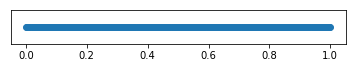

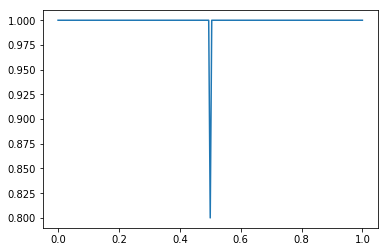

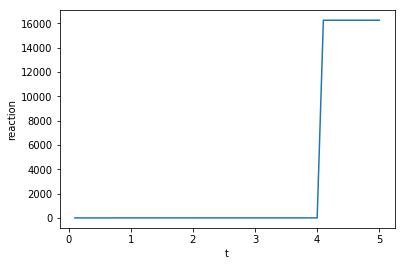

In [3]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def left_end(x):
    return fe.near(x[0], 0.0)


def right_end(x):
    return fe.near(x[0], l)


def middle_point(x):
    return fe.near(x[0], 0.5*l)


# --------------------
# Parameters
# --------------------
n = 200
l = 1.0
A = 1.0
lc = 0.01
Gc = 1.0

# Time parameters
t = 0.1
t_end = 5.0
dt = 0.1

# Iteration parameters
iterr = 1
error = 1.0
toll = 1.0e-4
maxiter = 30

# --------------------
# Define geometry
# --------------------
mesh = fe.IntervalMesh(n, 0.0, l)

fe.plot(mesh, "Mesh")
plt.show()

# --------------------
# Define spaces
# --------------------
V = fe.FunctionSpace(mesh, "CG", 1)
W = fe.FunctionSpace(mesh, "DG", 0)
P1 = fe.FiniteElement('P', fe.interval, 1)
element = fe.MixedElement([P1, P1])
M = fe.FunctionSpace(mesh, element)

# --------------------
# Boundary conditions
# --------------------
u_D = fe.Expression("t", t=0.0, degree=0)
BC_u_1 = fe.DirichletBC(M.sub(0), fe.Constant(0.0), left_end)
BC_u_2 = fe.DirichletBC(M.sub(0), u_D, right_end)
BC_u = [BC_u_1, BC_u_2]

# --------------------
# Initialization
# --------------------
X = fe.Function(M)
u, d = fe.split(X)

lower = fe.Function(M)
upper = fe.Function(M)
ninfty = fe.Function(V); ninfty.vector()[:] = -np.infty
pinfty = fe.Function(V); pinfty.vector()[:] = np.infty

fa = fe.FunctionAssigner(M, [V, V])
fa.assign(lower, [ninfty, fe.interpolate(fe.Constant(0.0), V)])
fa.assign(upper, [pinfty, fe.interpolate(fe.Constant(1.0), V)])

E = fe.Expression("1.0 - 0.2*near(x[0], 0.5, 0.001)", degree=1)
fe.plot(fe.project(E, V))
plt.show()

# --------------------
# Variational problem
# --------------------
En = (1-d)**2*E*A*(u.dx(0))**2*fe.dx + Gc*(0.5*d*d/lc + 0.5*lc*(d.dx(0))**2)*fe.dx

F = fe.derivative(En, X, fe.TestFunction(M))
H = fe.derivative(F, X, fe.TrialFunction(M))

snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "lu",
                            "relative_tolerance": 1e-4,
                            "maximum_iterations": 20,
                            "report": True,
                            "error_on_nonconvergence": False}}

problem = fe.NonlinearVariationalProblem(F, X, BC_u, H)
problem.set_bounds(lower, upper)

solver = fe.NonlinearVariationalSolver(problem)
solver.parameters.update(snes_solver_parameters)

# --------------------
# Time loop
# --------------------
force = []
time = []

while t < t_end:

    u_D.t = t

    solver.solve()
    uu, dd = X.split()

    fa.assign(lower, [ninfty, fe.interpolate(dd, V)])

    time.append(t)
    sigma = fe.project((1.0-dd)**2*E*A*uu.dx(0), W)
    force.append(sigma.vector()[n-1])

    t += dt

plt.plot(time, force)
plt.xlabel("t")
plt.ylabel("reaction")
plt.show()